In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

/home/sugeng/miniconda3/envs/rapids-24.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/sugeng/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2024-11-21 16:17:16.257556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 16:17:16.504423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732180636.599334  204268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732180636.625090  204268 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 16:17:16.861776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetV2L, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomBrightness
# from tensorflow.image import random_saturation
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip

In [4]:


# Define the ImageDataGenerator

dir = os.path.join(path, 'dataset/TomatoTrain')

train_ds = image_dataset_from_directory(
    dir,
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    shuffle=True,
    batch_size=32,
)
val_ds = image_dataset_from_directory(
    dir,
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    color_mode='rgb',
    seed=1337,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32,
)

Found 4986 files belonging to 2 classes.
Using 3989 files for training.


I0000 00:00:1731909921.868702   44663 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21894 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 4986 files belonging to 2 classes.
Using 997 files for validation.


In [5]:
train_ds.class_names

['freshtomato', 'rottentomato']

In [6]:
'''
Data Augmentation
- Rescale the pixel values to the [0, 1] range
- Standardize the data
- Enhancing  contrast and brightness
- Higher saturation
- Data augmentation
'''


data_augmentation = Sequential([
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip('horizontal'),
])



In [7]:
four_class_labels = ['freshcabbage', 'freshapples', 'freshbanana', 'freshcapsicum',   'freshtomato', 'rottencabbage','rottenapples', 'rottenbanana', 'rottencapsicum',  'rottentomato']
Freshness = ['Fresh', 'Rotten']
Object = 'Capsicum' # Object to classify

2024-11-18 13:05:22.539675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


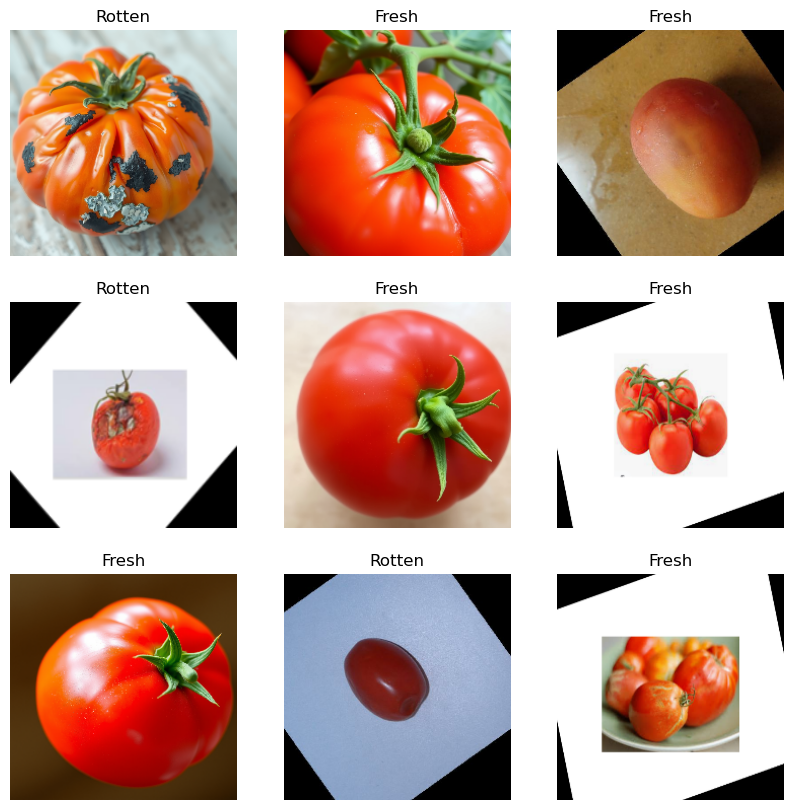

In [8]:
# Plot the first 9 images


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(Freshness[np.argmax(labels[i])])
        plt.axis("off")
        
plt.show()

2024-11-18 13:05:23.806373: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


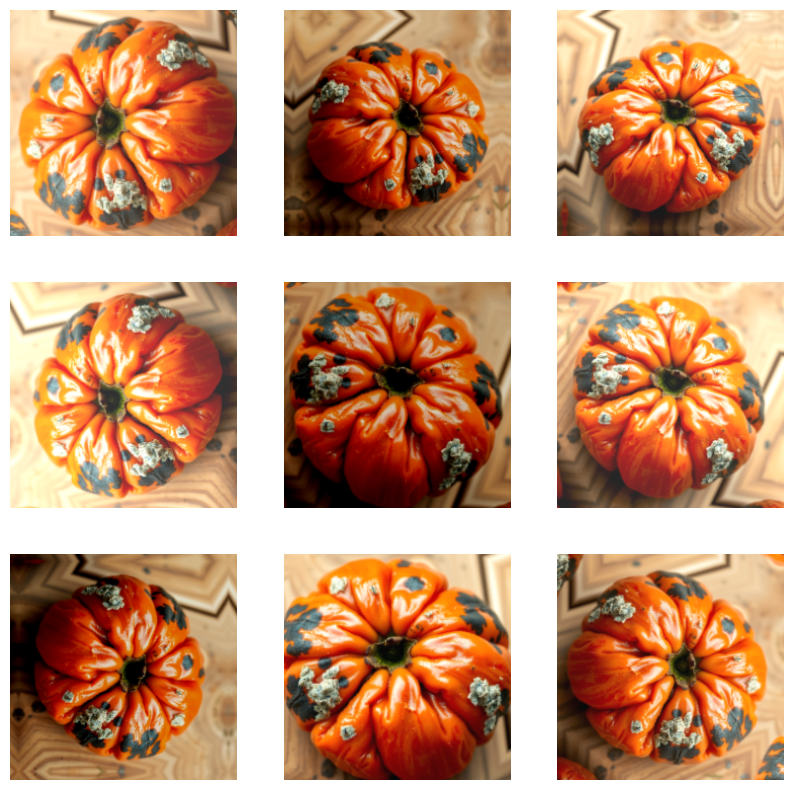

In [9]:
# Plot augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [10]:
# import pretrained model (resnet50)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
# Add data augmentation layer
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

In [11]:
#Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop])


Epoch 1/30


I0000 00:00:1731909927.691552   44786 cuda_dnn.cc:529] Loaded cuDNN version 90300


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.8913 - Precision: 0.8239 - Recall: 0.8239 - accuracy: 0.8239 - loss: 0.6999 - val_AUC: 0.9797 - val_Precision: 0.9168 - val_Recall: 0.9168 - val_accuracy: 0.9168 - val_loss: 0.1859
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.9867 - Precision: 0.9449 - Recall: 0.9449 - accuracy: 0.9449 - loss: 0.1434 - val_AUC: 0.9916 - val_Precision: 0.9539 - val_Recall: 0.9539 - val_accuracy: 0.9539 - val_loss: 0.1143
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.9947 - Precision: 0.9666 - Recall: 0.9666 - accuracy: 0.9666 - loss: 0.0918 - val_AUC: 0.9949 - val_Precision: 0.9609 - val_Recall: 0.9609 - val_accuracy: 0.9609 - val_loss: 0.0880
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - AUC: 0.9958 - Precision: 0.9644 - Recall: 0.9644 - accuracy: 0.9644 - loss: 0.0832 - val_AUC: 0.9949 - val_Precision: 0.9549 - val_Recall: 0.9549 - val_accuracy: 0.9549 - val_loss: 0.0914
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━

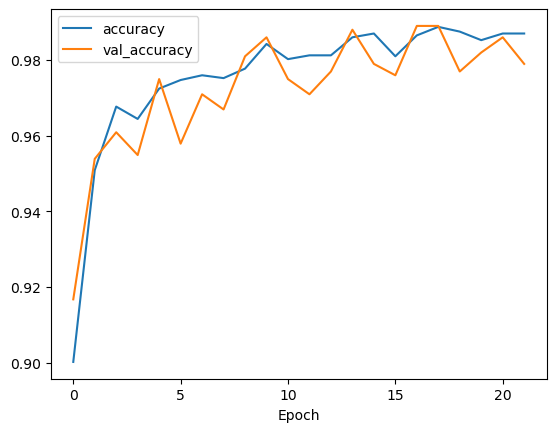

In [12]:
# Plot the training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

In [13]:
# save model to keras format
import tensorflow as tf
model_without_augmentation = Sequential(model.layers[1:]) # Exclude the data augmentation layer
model_without_augmentation.save('model.keras')

/home/sugeng/miniconda3/envs/rapids-24.10/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [14]:
# try to pred single image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/home/sugeng/Downloads/tomatofresh.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
print(Freshness[np.argmax(predictions[0])], Object, 'Prediction:', predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Fresh Capsicum Prediction: [9.9999988e-01 1.3727899e-07]


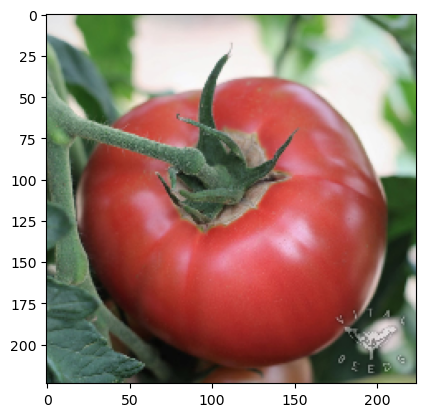

In [15]:
# plot the image
plt.imshow(img)
plt.show()


In [16]:
# reset GPU memory (always do this after training)
from numba import cuda 
device = cuda.get_current_device()
device.reset()